In [1]:
#下载数据集并解压
!wget https://filerepo.idzcn.com/dataset/assignment_1.zip
!unzip assignment_1.zip

--2023-11-15 03:03:31--  https://filerepo.idzcn.com/dataset/assignment_1.zip
Resolving filerepo.idzcn.com (filerepo.idzcn.com)... 124.225.184.41, 183.131.118.41, 123.184.58.41, ...
Connecting to filerepo.idzcn.com (filerepo.idzcn.com)|124.225.184.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155672 (66M) [application/zip]
Saving to: ‘assignment_1.zip.2’

assignment_1.zip.2  100%[===================>]  65.95M  3.96MB/s    in 19s     

2023-11-15 03:03:51 (3.52 MB/s) - ‘assignment_1.zip.2’ saved [69155672/69155672]

Archive:  assignment_1.zip
  inflating: creditcard.csv          


In [2]:
# 使用modin
import modin.pandas as pd
import modin.config as cfg
cfg.StorageFormat.put('hdk')

In [3]:
import modin.numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
#读取数据集
df=pd.read_csv("creditcard.csv")
df.head

<bound method BasePandasDataset.head of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.

In [5]:
#缺省值判断
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
#导入Intel® Extension for Scikit-learn库，调用patch函数加速
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #逻辑回归
from sklearn.tree import DecisionTreeClassifier #决策树
from sklearn.ensemble import RandomForestClassifier #随机森林
from sklearn.model_selection import cross_val_score #交叉验证计算accuracy
from sklearn.model_selection import GridSearchCV #网格搜索，获取最优参数
from sklearn.model_selection import StratifiedKFold #交叉验证
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score,accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [7]:
#对Amount和Time进行归一化处理
df['scaled_amount']=StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time']=StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Amount','Time'],axis=1,inplace=True)#删除Amount和Time
df.head

<bound method BasePandasDataset.head of                V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10  ...       V22       V23  \
0       0.239599  0.

In [8]:
#查看正常交易数据和欺诈交易数据的数量
print("正常交易数据：",len(df[df["Class"]==0]))
print("欺诈交易数据：",len(df[df["Class"]==1]))

正常交易数据： 284315
欺诈交易数据： 492


In [9]:
#分离特征和标签
X=df.drop("Class",axis=1)
y=df["Class"]

In [10]:
#针对正负样本数量极不平衡，这里采用SMOTE+undersampling解决数据不平衡
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
#over
over=SMOTE(sampling_strategy=0.1)
#under
under=RandomUnderSampler(sampling_strategy=1)
#pipeline
steps=[('o',over),('u',under)]
pipeline=Pipeline(steps=steps)
X_new,y_new=pipeline.fit_resample(X,y)
y_new.value_counts()

Class
0    28431
1    28431
Name: count, dtype: int64

In [11]:
#划分训练集和测试集
X_train,X_test,y_train,y_test=train_test_split(X_new,y_new,test_size=0.2,random_state=42)
X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

In [12]:
import time
#逻辑回归
def LR_gs(X_train,y_train):
    LR_param={
        'penalty':['l1','l2'],
        'C':[0.001,0.01,0.1,1,10,100,1000]
    }
    LR_gs=GridSearchCV(LogisticRegression(),param_grid=LR_param,n_jobs=-1,scoring='average_precision')
    LR_gs.fit(X_train,y_train)
    LR_estimators=LR_gs.best_estimator_ #最优参数
    LR_best_params=LR_gs.best_params_
    print(LR_best_params)
    return LR_estimators
dt_start = time.time()
LR_best_estimator=LR_gs(X_train,y_train)
print("逻辑回归模型用时：",time.time()-dt_start)

/home/u206438/.conda/envs/modin-hdk/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/u206438/.conda/envs/modin-hdk/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

{'C': 1000, 'penalty': 'l2'}
逻辑回归模型用时： 7.89497447013855


In [13]:
#决策树
def DT_gs(X_train,y_train):
    DT_param={
        'criterion':['gini','entrogy'],#衡量标准
        'max_depth':[5,10,15,20],#最大深度
        'min_samples_leaf':list(range(3,10,1))#最小叶子节点数
    }
    DT_gs=GridSearchCV(DecisionTreeClassifier(),param_grid=DT_param,n_jobs=-1,scoring='average_precision')
    DT_gs.fit(X_train,y_train)
    DT_estimators=DT_gs.best_estimator_
    DT_best_params=DT_gs.best_params_
    print(DT_best_params)
    return DT_estimators
dt_start=time.time()
DT_best_estimator=DT_gs(X_train,y_train)
print("决策树模型用时：",time.time()-dt_start)

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 8}
决策树模型用时： 25.054783821105957


In [14]:
#随机森林
def RFC_gs(X_train,y_train):
    RFC_param={
        'n_estimators':[100,150,200],#多少棵树
        'criterion':['gini','entrogy'],#衡量标准
        'max_depth':[5,10,15,20],#最大深度
        'min_samples_split':list(range(2,10,1))#最小分割样本
    }
    RFC_gs=GridSearchCV(RandomForestClassifier(),param_grid=RFC_param,n_jobs=-1,scoring='average_precision')
    RFC_gs.fit(X_train,y_train)
    RFC_estimators=RFC_gs.best_estimator_
    RFC_best_params=RFC_gs.best_params_
    print(RFC_best_params)
    return RFC_estimators
dt_start=time.time()
RFC_best_estimator=RFC_gs(X_train,y_train) 
print("随机森林模型用时：",time.time()-dt_start)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}
随机森林模型用时： 130.6597638130188


In [15]:
result_df=pd.DataFrame(columns=['Accuracy','F1-score','Recall','Precision','AUC_ROC','AUPRC'],
                       index=['LR','DT','RFC'])

def caculate(models,X_test,y_test):
    #计算各种参数的值
    Accuracy_result=[]
    F1_score_result=[]
    Recall_result=[]
    Precision_result=[]
    AUC_ROC_result=[]
    AUPRC_result=[]
    
    for model in models:
        y_pred=model.predict(X_test)
        accuracy=accuracy_score(y_test,y_pred) #计算准确率
        precision,recall,f1_score,_=precision_recall_fscore_support(y_test,y_pred)#计算精确度，召回率，f1
        auc_roc=roc_auc_score(y_test, y_pred)  # 计算AUC
        auprc = average_precision_score(y_test, y_pred)#计算AUPRC
        
        Accuracy_result.append(accuracy)
        Precision_result.append(precision)
        Recall_result.append(recall)
        F1_score_result.append(f1_score)
        AUC_ROC_result.append(auc_roc)
        AUPRC_result.append(auprc)
        
    return Accuracy_result,F1_score_result,Recall_result,Precision_result,AUC_ROC_result,AUPRC_result

In [16]:
#经测试集训练出的各模型的测试结果
best_models=[LR_best_estimator,DT_best_estimator,RFC_best_estimator]

Accuracy_results,F1_results,Recall_results,Precision_results,AUC_ROC_results,AUPRC_results=caculate(best_models,X_test,y_test)

result_df['Accuracy']=Accuracy_results
result_df['F1-score']=F1_results
result_df['Recall']=Recall_results
result_df['Precision']=Precision_results
result_df['AUC_ROC']=AUC_ROC_results
result_df['AUPRC']=AUPRC_results
result_df

,Accuracy,F1-score,Recall,Precision,AUC_ROC,AUPRC
LR,0.947859,"[0.9489277409353198, 0.9467444993264481]","[0.9745267999292411, 0.9215034965034965]","[0.9246391406512252, 0.9734072022160665]",0.948015,0.936478
DT,0.979689,"[0.9795593310326519, 0.9798165137614679]","[0.9791261277197948, 0.9802447552447553]","[0.9799929178470255, 0.9793886462882097]",0.979685,0.969976
RFC,0.998593,"[0.9985848222182911, 0.9986013986013986]","[0.9985848222182911, 0.9986013986013986]","[0.9985848222182911, 0.9986013986013986]",0.998593,0.997908


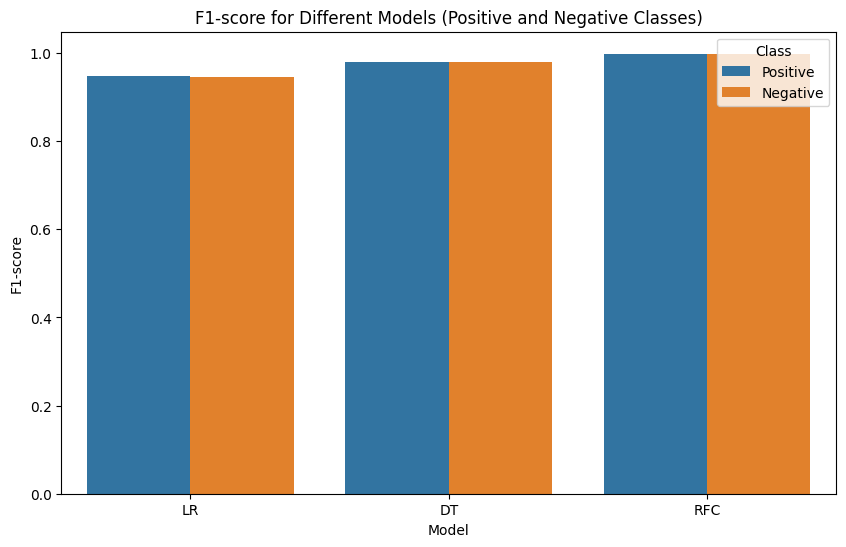

In [17]:
#F1-score的可视化
import seaborn as sns
import matplotlib.pyplot as plt

# 将 F1-score 列中的两个值拆分为两列，命名为 F1-score_Pos 和 F1-score_Neg
result_df[['F1-score_Pos', 'F1-score_Neg']] = pd.DataFrame(result_df['F1-score'].tolist(), index=result_df.index)

# 创建一个新的 DataFrame 以便 seaborn 能够正确处理数据
f1_data = pd.DataFrame({
    'Model': result_df.index.tolist() * 2,  # 乘以 2 是因为每个模型有两个 F1-score
    'F1-score': result_df['F1-score_Pos'].values.tolist() + result_df['F1-score_Neg'].values.tolist(),
    'Class': ['Positive'] * len(result_df) + ['Negative'] * len(result_df)  # 添加一个表示类别的列
})

# 绘制 F1-score
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1-score', hue='Class', data=f1_data)
plt.title('F1-score for Different Models (Positive and Negative Classes)')
plt.show()

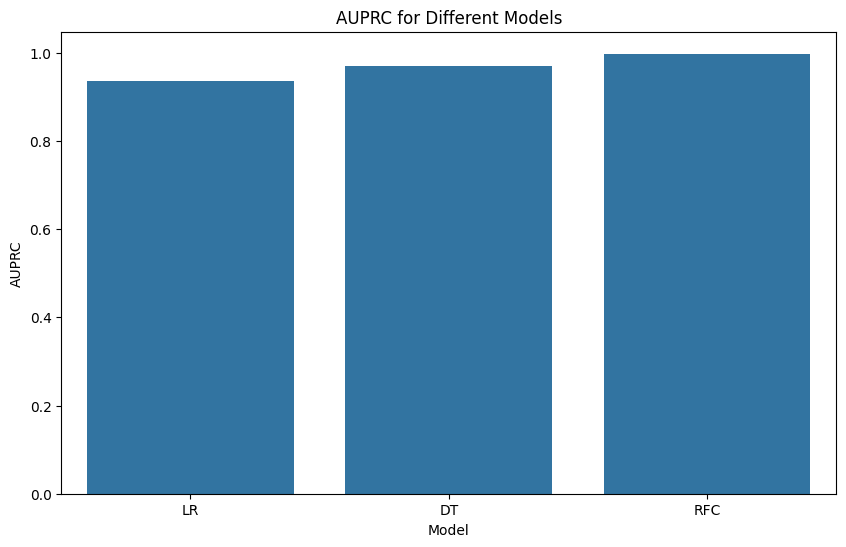

In [18]:
#AUPRC的可视化
import seaborn as sns
import matplotlib.pyplot as plt

# 创建一个新的 DataFrame 以便 seaborn 处理数据
auprc_data = pd.DataFrame({
    'Model': result_df.index.tolist(),
    'AUPRC': result_df['AUPRC'].values
})

# 绘制 AUPRC
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='AUPRC', data=auprc_data)
plt.title('AUPRC for Different Models')
plt.show()

In [19]:
#比较来看选择随机森林模型效果最佳